In [6]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
## GURT parameters reading from file
file = open('DATA/GURT_parameters/AmaxGOST(f)_f=8,80,1.txt', 'r')

# First line - directions number
first_line = file.readline()
first_line = first_line.split()

directions = []
for i in range(1, len(first_line)):
    directions.append(int(first_line[i]))
no_of_directions = len(directions)

# Skip blank line
_ = file.readline()

# Read data by freqency
freq_num = 73
a_eff_gost = np.zeros((no_of_directions, freq_num), dtype=float)
frequency = np.zeros((freq_num), dtype=float)

for i in range(freq_num):
    line = file.readline()
    line = line.split()
    frequency[i] = float(line[0])
    for j in range(1, no_of_directions+1):
        a_eff_gost[j-1, i] = float(line[j])

Text(0, 0.5, 'Aeff, m2')

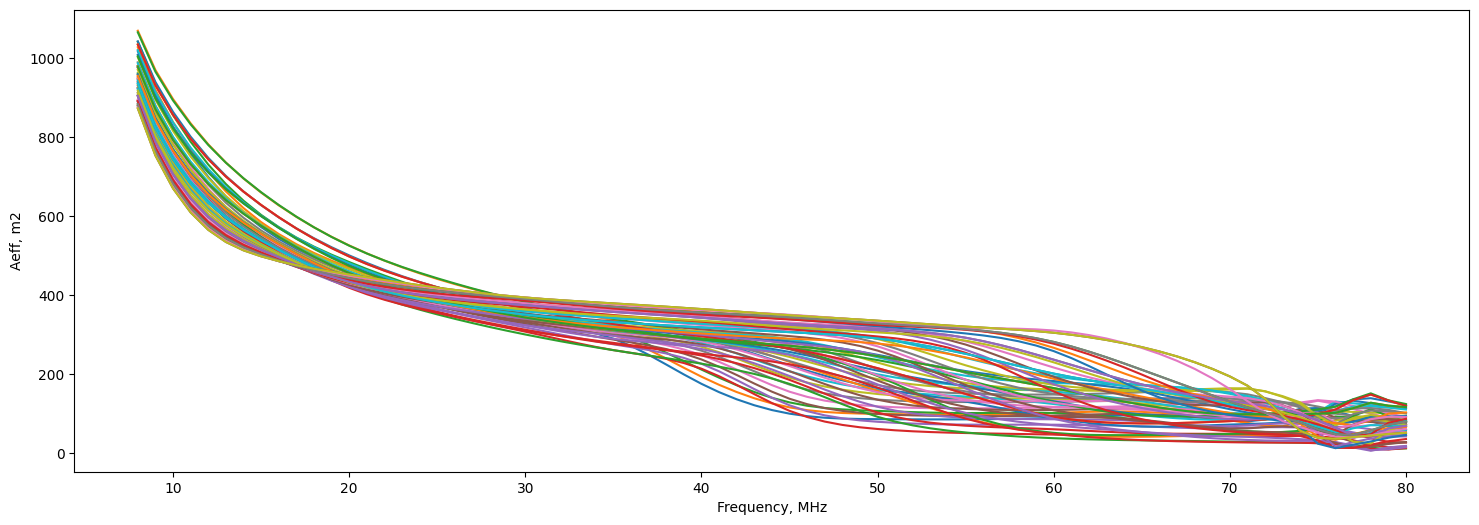

In [8]:
fig, ax0 = plt.subplots(1, 1, figsize=(18, 6)) 
for i in range(no_of_directions):
    ax0.plot(frequency[:], a_eff_gost[i, :])
ax0.set_xlabel('Frequency, MHz')
ax0.set_ylabel('Aeff, m2')

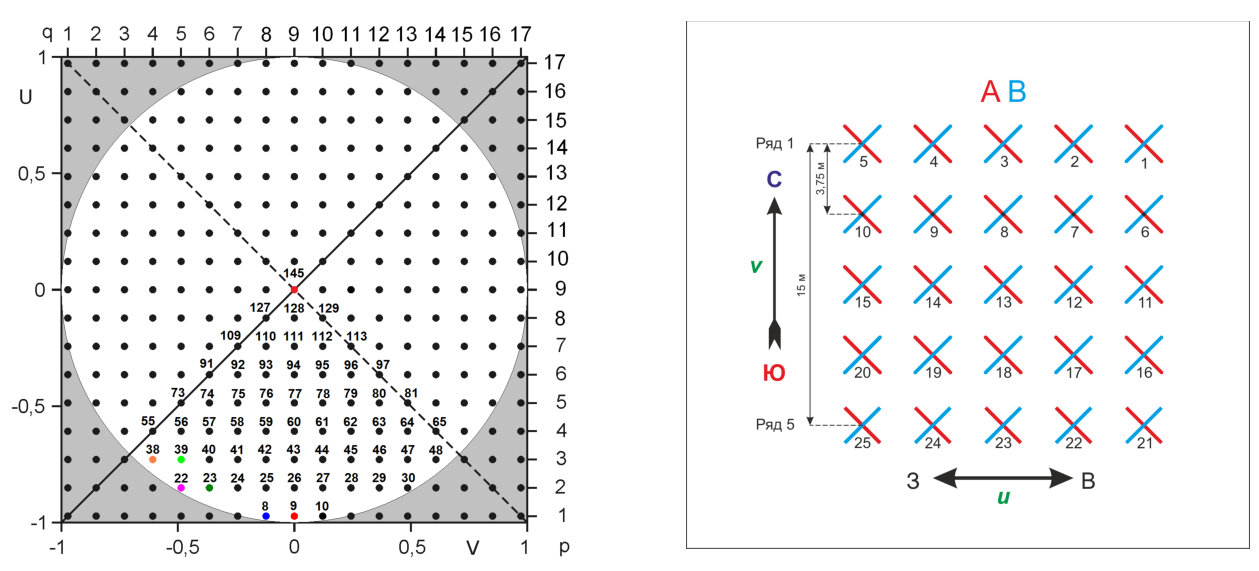

In [9]:
img_0 = mpimg.imread('DATA/GURT_parameters/1_UV_1-289.png')
img_1 = mpimg.imread('DATA/GURT_parameters/GURT_polarization.png')

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))
ax0.imshow(img_0)
ax0.axis('off')
ax1.imshow(img_1)
ax1.axis('off')

plt.show()

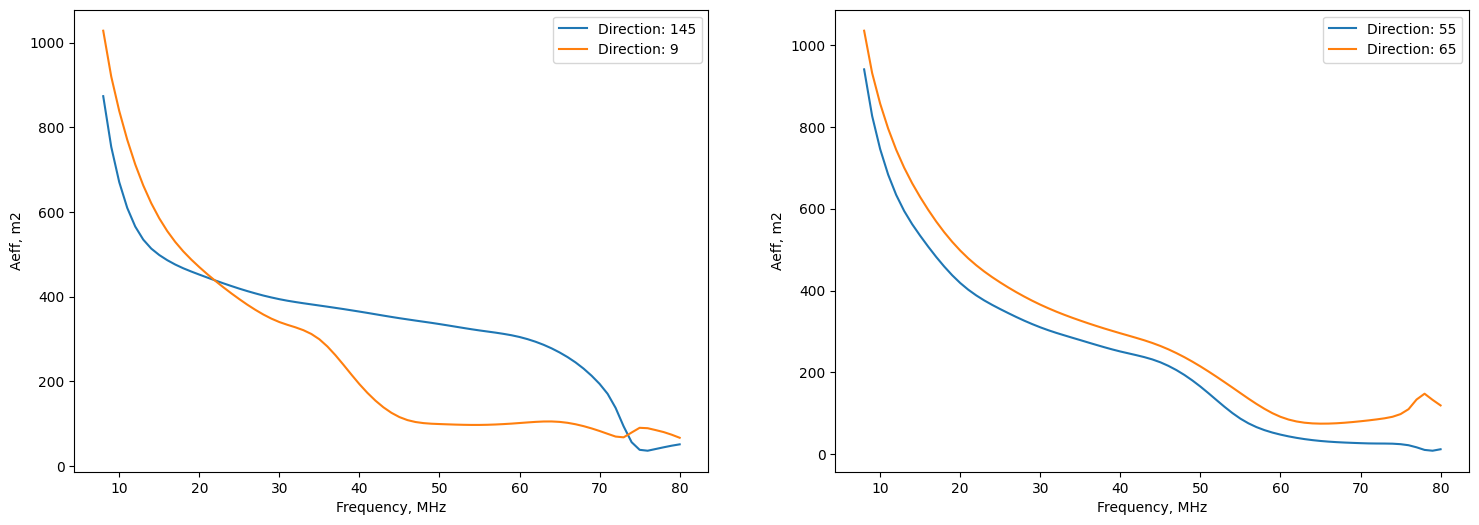

In [10]:
dir_0 = 145
dir_1 = 9
dir_2 = 55
dir_3 = 65

ind_0 = directions.index(dir_0)
ind_1 = directions.index(dir_1)
ind_2 = directions.index(dir_2)
ind_3 = directions.index(dir_3)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18,6)) 
ax0.plot(frequency[:], a_eff_gost[ind_0, :], label=('Direction: ' + str(dir_0)))
ax0.plot(frequency[:], a_eff_gost[ind_1, :], label=('Direction: ' + str(dir_1)))
ax0.set_xlabel('Frequency, MHz')
ax0.set_ylabel('Aeff, m2')
ax0.legend()
ax1.plot(frequency[:], a_eff_gost[ind_2, :], label=('Direction: ' + str(dir_2)))
ax1.plot(frequency[:], a_eff_gost[ind_3, :], label=('Direction: ' + str(dir_3)))
ax1.set_xlabel('Frequency, MHz')
ax1.set_ylabel('Aeff, m2')
ax1.legend()